<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1: Kaiting Liu

# Student 2: Sihan Zhu

# Student 3: Ruozhu Yao

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

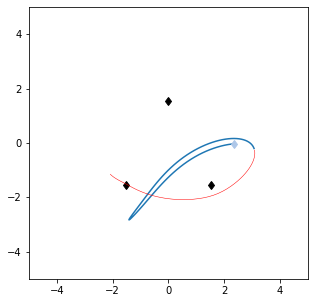

Charges are [-0.28769295 -0.88439161 -0.24215657]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [8]:
#todo

## Model Implementation

In [9]:
#todo

## Model Training

In [10]:
#todo

## Evaluation

In [11]:
#todo

# Task 3.2

## Data Handling and Preprocessing

In [12]:
#todo

In [13]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, input_data, label_data):
        self.input_data = input_data
        self.label_data = label_data
        
    def __getitem__(self, index):
        input = self.input_data[index]
        label = self.label_data[index]
        return torch.FloatTensor(input), torch.FloatTensor(label)
        
    def __len__(self):
        return len(self.label_data)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
train_dataset = MyDataset(simulation_train, simulation_continued_train)
# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,pin_memory=True)
# print(train_loader[0])
for x, y in train_loader:
  print(x.size(), y.size())
  break
# for x, y in enumerate(train_loader):
  


torch.Size([1, 103, 2]) torch.Size([1, 54, 2])


## Model Implementation

In [16]:
#todo

In [17]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, output_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hid_dim, num_layers=n_layers, dropout = dropout, batch_first=True)
        self.linear = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, input):
        out, hidden = self.rnn(input)
        output = self.linear(out)
        
        return output, hidden

In [18]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, output_dim, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(input_dim, hid_dim, n_layers, dropout = dropout,batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
        
    def forward(self, input, hidden):
        # pytorch expects a sequence, but we use batches with 1 element, i.e., sequence length 1
        input = input.unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        
        prediction = self.fc_out(output.squeeze(1))  # squeeze our 'sequence length 1' away
        #prediction = [batch size, output dim]      
        
        return prediction, hidden

In [19]:
import torch.optim as optim
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        ### Your code here ###
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.5)
        # self.optimizer = optim.Adam(self.parameters(),lr=0.005,weight_decay=0.01)
        # self.optimizer = optim.Adam(self.parameters(),weight_decay=0.0001)
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.5)
        self.optimizer = optim.Adam(self.parameters())
        self.criterion = nn.L1Loss()
        

    def forward(self, src, trg, teacher_forcing_ratio = 0):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.
        
        Inputs:
        src: 
        trg:  
        teacher_forcing_ratio: probability to use teacher forcing, e.g. 0.5 we use ground-truth target sentence 50% of the time
        
        Outputs:
        outputs: index representation of the predicted positions with shape [batch_size, trg_len, element_size]
        """
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        element_size = trg.shape[2]

        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, element_size).to(self.device)
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        output, hidden = self.encoder(src)
        
        # first input to the decoder is the <sos> tokens
        input = output[:, -1, :].clone()
        outputs[:,0,:] = input
        for t in range(1, trg_len):
            output, hidden= self.decoder(input, hidden)

            #place predictions in a tensor holding predictions for each time point
            outputs[:,t,:] = output.squeeze(1)
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #if teacher forcing, use actual next positions as next input
            #if not, use predicted positions
            input = trg[:,t,:].clone() if teacher_force else outputs[:,t,:].clone()

        return outputs

## Model Training

In [ ]:
#todo

In [20]:
BATCH_SIZE = 1
N_EPOCHS = 50
DROPOUT = 0.5
N_LAYERS = 4 #paper uses 4
HIDDEN_DIM = 70 #dimension of the lstm's hidden state
INPUT_DIM = 2
OUTPUT_DIM = 2

In [21]:
from torch.optim import optimizer
# initiate seq2seq translation model
enc = Encoder(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
dec = Decoder(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)

seq2seq = Seq2Seq(enc, dec, device).to(device)
train_dataset = MyDataset(simulation_train, simulation_continued_train)
valid_dataset = MyDataset(simulation_valid, simulation_continued_valid)
# data loader
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, collate_fn=collate_batch)
# print(train_loader[0])



In [22]:
import time
from tqdm import tqdm
from torch.utils.data.dataloader import default_collate
from sklearn.metrics import r2_score


def train(dataset):
    epoch_loss = 0
    seq2seq.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    scores = []

    ### Your code here ###
    for i, (src, trg) in enumerate(tqdm(dataloader)):
        seq2seq.optimizer.zero_grad()
        output = seq2seq(src, trg)
        
        loss = seq2seq.criterion(output, trg)
        
        loss.backward() # inputs=list(seq2seq.parameters())
        
        # torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), clip)
        
        seq2seq.optimizer.step()
        
        epoch_loss += loss.item()
        
        if device == torch.device("cuda"):
          torch.cuda.empty_cache()
        
        # print(output.cpu().detach().numpy()[0])
        # calculate r2 score (use [0] to reduce the dimension of the 3d numpy array to 2d)
        scores.append(r2_score(output.cpu().detach().numpy()[0], trg.cpu().detach().numpy()[0]))
    avg_score = np.mean(scores)
    return avg_score, epoch_loss / len(dataloader)

def evaluate(dataset):
    epoch_loss = 0
    seq2seq.eval()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    scores = []
    with torch.no_grad():

        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            loss = seq2seq.criterion(output, trg)
            
            epoch_loss += loss.item()

            scores.append(r2_score(output.cpu().detach().numpy()[0], trg.cpu().detach().numpy()[0]))
            
            if device == torch.device("cuda"):
              torch.cuda.empty_cache()

        avg_score = np.mean(scores)
    
    return avg_score, epoch_loss / len(dataloader)


best_valid_loss = float('inf')
train_loss_list = []; 
val_loss_list = []
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()

    train_score,train_loss = train(train_dataset)
    val_score,val_loss = evaluate(valid_dataset)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    if val_loss < best_valid_loss:
        best_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'p3_3-model.pt')
    
    print('-' * 76)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'valid loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time, 
                                           train_loss_list[-1],
                                           val_loss_list[-1]))
    print('-' * 76)

100%|██████████| 150/150 [00:08<00:00, 16.86it/s]


----------------------------------------------------------------------------
| end of epoch   0 | time: 10.26s | train loss    1.342 valid loss    1.312 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.18it/s]


----------------------------------------------------------------------------
| end of epoch   1 | time: 10.09s | train loss    1.210 valid loss    1.275 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:09<00:00, 16.17it/s]


----------------------------------------------------------------------------
| end of epoch   2 | time: 10.66s | train loss    1.144 valid loss    1.380 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.22it/s]


----------------------------------------------------------------------------
| end of epoch   3 | time: 10.06s | train loss    1.122 valid loss    1.249 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.24it/s]


----------------------------------------------------------------------------
| end of epoch   4 | time: 10.05s | train loss    1.084 valid loss    1.218 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.07it/s]


----------------------------------------------------------------------------
| end of epoch   5 | time: 10.13s | train loss    1.026 valid loss    1.226 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.06it/s]


----------------------------------------------------------------------------
| end of epoch   6 | time: 10.16s | train loss    1.032 valid loss    1.014 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.20it/s]


----------------------------------------------------------------------------
| end of epoch   7 | time: 10.10s | train loss    0.955 valid loss    1.032 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.15it/s]


----------------------------------------------------------------------------
| end of epoch   8 | time: 10.38s | train loss    0.919 valid loss    1.077 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 16.70it/s]


----------------------------------------------------------------------------
| end of epoch   9 | time: 10.62s | train loss    0.928 valid loss    1.075 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.26it/s]


----------------------------------------------------------------------------
| end of epoch  10 | time: 10.05s | train loss    0.882 valid loss    1.167 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.36it/s]


----------------------------------------------------------------------------
| end of epoch  11 | time: 10.02s | train loss    0.861 valid loss    0.892 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.26it/s]


----------------------------------------------------------------------------
| end of epoch  12 | time: 10.04s | train loss    0.837 valid loss    0.968 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.25it/s]


----------------------------------------------------------------------------
| end of epoch  13 | time: 10.05s | train loss    0.768 valid loss    0.958 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.27it/s]


----------------------------------------------------------------------------
| end of epoch  14 | time: 10.03s | train loss    0.788 valid loss    0.936 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.23it/s]


----------------------------------------------------------------------------
| end of epoch  15 | time: 10.07s | train loss    0.747 valid loss    0.878 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.04it/s]


----------------------------------------------------------------------------
| end of epoch  16 | time: 10.18s | train loss    0.693 valid loss    0.808 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.09it/s]


----------------------------------------------------------------------------
| end of epoch  17 | time: 10.13s | train loss    0.704 valid loss    0.830 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.30it/s]


----------------------------------------------------------------------------
| end of epoch  18 | time: 10.03s | train loss    0.692 valid loss    0.847 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 16.93it/s]


----------------------------------------------------------------------------
| end of epoch  19 | time: 10.22s | train loss    0.690 valid loss    0.866 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.10it/s]


----------------------------------------------------------------------------
| end of epoch  20 | time: 10.13s | train loss    0.673 valid loss    0.796 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.04it/s]


----------------------------------------------------------------------------
| end of epoch  21 | time: 10.69s | train loss    0.637 valid loss    0.858 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.28it/s]


----------------------------------------------------------------------------
| end of epoch  22 | time: 10.03s | train loss    0.663 valid loss    0.780 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.09it/s]


----------------------------------------------------------------------------
| end of epoch  23 | time: 10.12s | train loss    0.643 valid loss    0.739 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.14it/s]


----------------------------------------------------------------------------
| end of epoch  24 | time: 10.11s | train loss    0.622 valid loss    0.762 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.25it/s]


----------------------------------------------------------------------------
| end of epoch  25 | time: 10.04s | train loss    0.591 valid loss    0.848 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.18it/s]


----------------------------------------------------------------------------
| end of epoch  26 | time: 10.11s | train loss    0.606 valid loss    0.793 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.14it/s]


----------------------------------------------------------------------------
| end of epoch  27 | time: 10.11s | train loss    0.575 valid loss    0.739 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.15it/s]


----------------------------------------------------------------------------
| end of epoch  28 | time: 10.10s | train loss    0.563 valid loss    0.785 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.14it/s]


----------------------------------------------------------------------------
| end of epoch  29 | time: 10.10s | train loss    0.557 valid loss    0.743 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.15it/s]


----------------------------------------------------------------------------
| end of epoch  30 | time: 10.11s | train loss    0.567 valid loss    0.755 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 16.87it/s]


----------------------------------------------------------------------------
| end of epoch  31 | time: 10.24s | train loss    0.551 valid loss    0.734 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.03it/s]


----------------------------------------------------------------------------
| end of epoch  32 | time: 10.16s | train loss    0.555 valid loss    0.660 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.17it/s]


----------------------------------------------------------------------------
| end of epoch  33 | time: 10.09s | train loss    0.555 valid loss    0.761 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.10it/s]


----------------------------------------------------------------------------
| end of epoch  34 | time: 10.14s | train loss    0.553 valid loss    0.737 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 16.94it/s]


----------------------------------------------------------------------------
| end of epoch  35 | time: 10.23s | train loss    0.519 valid loss    0.731 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.10it/s]


----------------------------------------------------------------------------
| end of epoch  36 | time: 10.14s | train loss    0.510 valid loss    0.687 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.24it/s]


----------------------------------------------------------------------------
| end of epoch  37 | time: 10.07s | train loss    0.506 valid loss    0.694 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.13it/s]


----------------------------------------------------------------------------
| end of epoch  38 | time: 10.12s | train loss    0.531 valid loss    0.713 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.11it/s]


----------------------------------------------------------------------------
| end of epoch  39 | time: 10.15s | train loss    0.481 valid loss    0.770 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.08it/s]


----------------------------------------------------------------------------
| end of epoch  40 | time: 10.15s | train loss    0.478 valid loss    0.740 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.25it/s]


----------------------------------------------------------------------------
| end of epoch  41 | time: 10.59s | train loss    0.486 valid loss    0.752 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.19it/s]


----------------------------------------------------------------------------
| end of epoch  42 | time: 10.09s | train loss    0.474 valid loss    0.702 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.28it/s]


----------------------------------------------------------------------------
| end of epoch  43 | time: 10.03s | train loss    0.475 valid loss    0.692 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.13it/s]


----------------------------------------------------------------------------
| end of epoch  44 | time: 10.14s | train loss    0.464 valid loss    0.704 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.10it/s]


----------------------------------------------------------------------------
| end of epoch  45 | time: 10.12s | train loss    0.456 valid loss    0.679 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.44it/s]


----------------------------------------------------------------------------
| end of epoch  46 | time:  9.95s | train loss    0.422 valid loss    0.669 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.07it/s]


----------------------------------------------------------------------------
| end of epoch  47 | time: 10.14s | train loss    0.465 valid loss    0.651 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 16.88it/s]


----------------------------------------------------------------------------
| end of epoch  48 | time: 10.25s | train loss    0.445 valid loss    0.689 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:08<00:00, 17.10it/s]


----------------------------------------------------------------------------
| end of epoch  49 | time: 10.18s | train loss    0.486 valid loss    0.633 
----------------------------------------------------------------------------


## Evaluation

quantitive performance

investigate a few individual cases;

Baseline comparison

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'Loss')

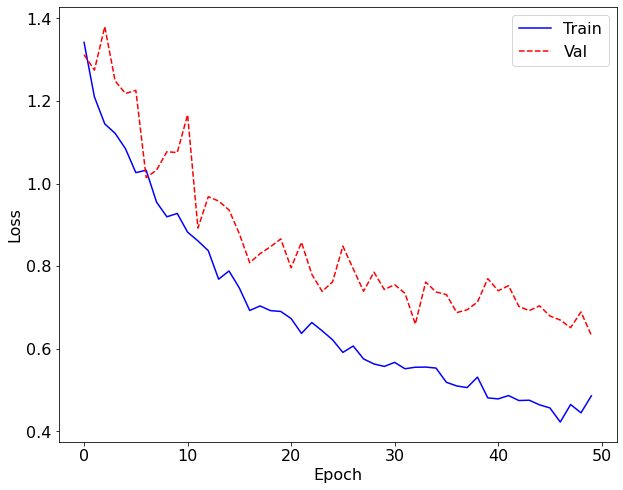

In [23]:
### Plot the training/validation accuracy vs. epochs ###
%pylab inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10,8))

fnt=16
ax.plot(train_loss_list, color='blue', label='Train')
ax.plot(val_loss_list, color='red', linestyle='--', label='Val')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt)

In [31]:
def test(dataset):
    seq2seq.eval()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    loss_history = []
    with torch.no_grad():

        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            loss = seq2seq.criterion(output, trg)

            loss_history.append(loss.cpu())
            
            if device == torch.device("cuda"):
              torch.cuda.empty_cache()
    worst_inds= np.argpartition(loss_history,-5)[-5:]
    best_inds= np.argpartition(loss_history, 5)[:5]
    
    return best_inds,worst_inds

In [32]:
test_dataset = MyDataset(simulation_test, simulation_continued_test)
best_inds,worst_inds = test(test_dataset)

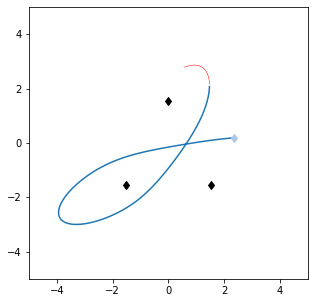

Example with lowest loss: Charges are [-0.9355202  -0.96350592 -0.81551009]


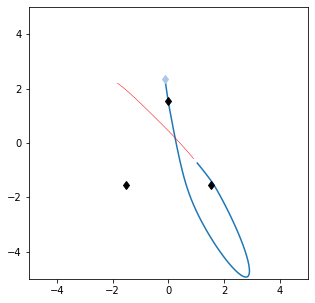

Example with lowest loss: Charges are [-0.27367139 -0.9003474  -0.82114085]


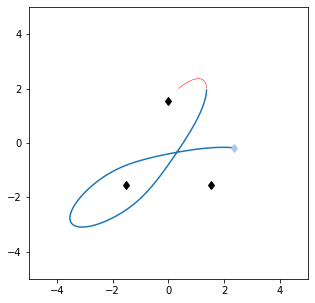

Example with lowest loss: Charges are [-0.98451836 -0.1667747  -0.34789858]


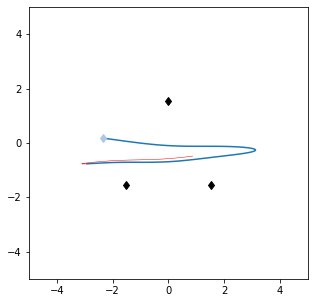

Example with lowest loss: Charges are [-0.1375296  -0.05280612 -0.95305736]


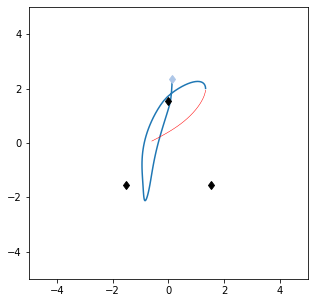

Example with lowest loss: Charges are [-0.71249709 -0.94338288 -0.73234647]


In [33]:
for best_i in best_inds:
  plot_example(simulation_test[best_i], simulation_continued_test[best_i])
  print(f'Example with lowest loss: Charges are {charges_train[best_i]}')

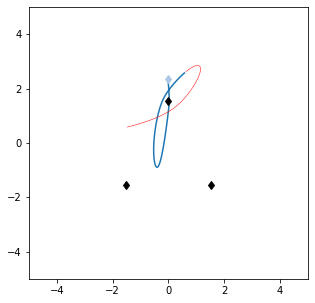

Example with highest loss:Charges are [-0.07392311 -0.39150585 -0.22594102]


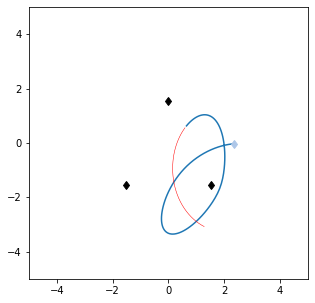

Example with highest loss:Charges are [-0.89750872 -0.08494919 -0.41676935]


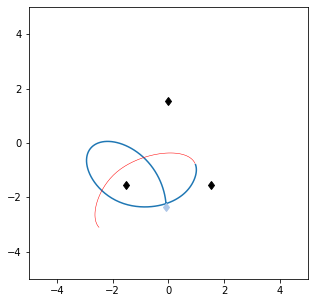

Example with highest loss:Charges are [-0.44760574 -0.91493189 -0.844136  ]


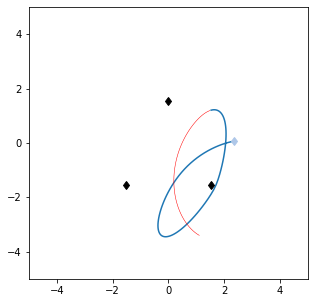

Example with highest loss:Charges are [-0.17141219 -0.38988138 -0.21918364]


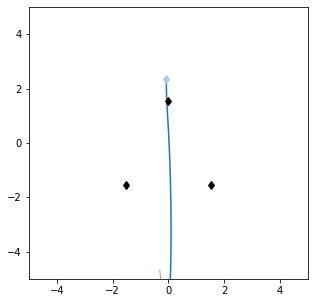

Example with highest loss:Charges are [-0.75079983 -0.27656042 -0.16604467]


In [34]:
for worst_i in worst_inds:
  plot_example(simulation_test[worst_i], simulation_continued_test[worst_i])
  print(f'Example with highest loss:Charges are {charges_train[worst_i]}')